## Figure 7. Comparing RDD for different network sizes

Imports

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
import pandas as pd
import seaborn as sns

from lib.lif import LIF, ParamsLIF
from lib.causal import causaleffect_maxv, causaleffect_maxv_linear, causaleffect_maxv_sp

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Angle between two vectors
def alignment(a,b):
    
    da = np.dot(a,a)
    db = np.dot(b,b)
    if da > 0 and db > 0:
        return 180/np.pi*np.arccos(np.dot(a,b)/np.sqrt(da*db))
    else:
        return 360.
    
def mse(pred,true):
    return np.mean((pred - true)**2)

## A. Dependence on $N$ and $c$

In [3]:
nsims = 5
cvals = np.array([0.01, 0.25, 0.5, 0.75, 0.99])
#cvals = np.array([0.01, 0.25, 0.5])
#Nvals = np.logspace(1, 3, 6, dtype = int)
Nvals = np.logspace(1, 3, 4, dtype = int)

tau_s = 0.020
dt = 0.001
t = 100
sigma = 10
x = 0
p = 0.1
DeltaT = 20

W = np.array([12, 9])

params = ParamsLIF(sigma = sigma)
lif = LIF(params, t = t)
lif.W = W

t_filter = np.linspace(0, 1, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

#c (correlation between noise inputs)
beta_mse_rd_c = np.zeros((len(cvals), len(Nvals), nsims))
beta_mse_fd_c = np.zeros((len(cvals), len(Nvals), nsims))
beta_mse_bp_c = np.zeros((len(cvals), len(Nvals), nsims))

beta_mse_rd_c_linear = np.zeros((len(cvals), len(Nvals), nsims))
beta_mse_fd_c_linear = np.zeros((len(cvals), len(Nvals), nsims))

In [65]:
#beta_sp_c = np.zeros((len(cvals), params.n))

target = 0.1
W = 10*np.ones(int(Nvals[-1]))
#W = np.random.randn(int(Nvals[-1]))*5
V = np.random.randn(int(Nvals[-1]))*5

#cost = lambda s,a: (np.dot(a[0:len(s)], s) - len(s)*target)**2
cost = lambda s,a: np.sqrt((np.dot(a[0:len(s)], s) - target)**2)

#Cost function
#B1 = 1
#B2 = 2
#x = .01
#y = 0.1
#z = 0

#cost = lambda s1, s2: (B1*s1-x)**2 + (z+B2*s2 - B2*(B1*s1-y)**2)**2

In [5]:
params.c = 0.99
params.n = 10
lif.setup(params)
lif.W = W[0:10]
(v, h, _, _, u) = lif.simulate(DeltaT)

In [6]:
h.shape
n_units = 10
s = np.zeros(h.shape)
for l in range(10):
    s[l,:] = np.convolve(h[l,:], exp_filter)[0:h.shape[1]]
cost_s = cost(s,V[0:n_units])

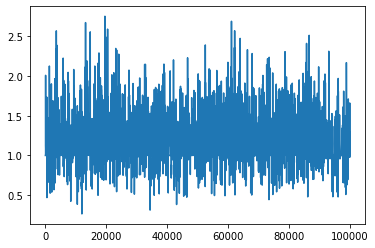

In [7]:
plot(cost_s)

In [39]:
#Get 'true' causal effects by estimating with unconfounded data

#Actually, true causal effects are estimated with confounded data for all but one
#neuron. Use this one neuron as the measure of causal effect.
DeltaT = 20
nsims = 10
i = 0; c = 0.0
beta_true_c = np.zeros((len(Nvals), nsims, np.max(Nvals)))
mean_beta_true_c = np.zeros(len(Nvals))
for j, n_units in enumerate(Nvals):    
    print("Running %d simulations with c=%s, n=%d"%(nsims, c, n_units))
    params.c = c
    params.n = n_units
    lif = LIF(params, t = t)
    lif.W = W[0:n_units]
    for k in range(nsims):
        (v, h, _, _, u) = lif.simulate_allbutonecorrelated(DeltaT)
        #(v, h, _, _, u) = lif.simulate(DeltaT)
        s = np.zeros(h.shape)
        for l in range(n_units):
            s[l,:] = np.convolve(h[l,:], exp_filter)[0:h.shape[1]]
        cost_s = cost(s,V[0:n_units])                
        beta_true_c[j,k,0:n_units] = causaleffect_maxv(u, cost_s, DeltaT, 1, params)
        #print(beta_fd_c)
        
    mean_beta_true_c[j] = np.mean(beta_true_c[j,:,0])
    #This is done wrong... shit

mean_beta_true_c.shape

Running 10 simulations with c=0.0, n=10
Running 10 simulations with c=0.0, n=46
Running 10 simulations with c=0.0, n=215
Running 10 simulations with c=0.0, n=1000


(4,)

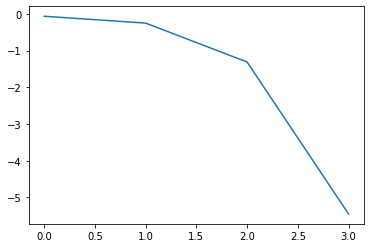

In [40]:
#copy mean_beta_true_c from the first index to all of them
plt.plot(mean_beta_true_c)

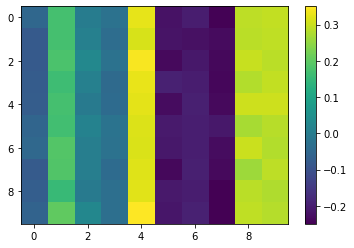

In [45]:
i = 0
plt.imshow(beta_true_c[i,:,0:Nvals[i]], aspect = 'auto')
plt.colorbar()

In [42]:
beta_true_c.shape

(4, 10, 1000)

In [29]:
mean_beta_true_c = np.broadcast_to(mean_beta_true_c, [1000,4])

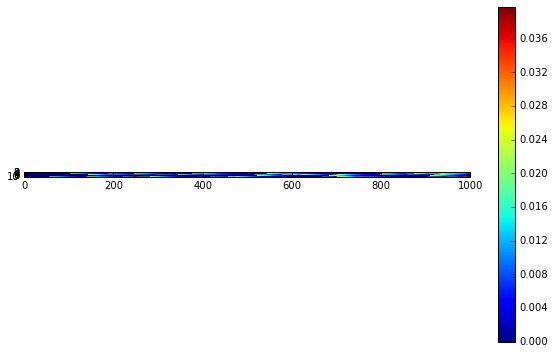

In [13]:
plt.imshow(s[:,0:1000])
plt.colorbar()

In [69]:
#Compute causal effects for different c values
DeltaT = 20
nsims = 10

cvals = np.array([0.01, 0.25, 0.5, 0.75, 0.99])
#cvals = np.array([0.01])

mean_beta_c = np.zeros((len(cvals), len(Nvals), nsims))
mean_beta_fd_c = np.zeros((len(cvals), len(Nvals), nsims))

for i,c in enumerate(cvals):
    for j, n_units in enumerate(Nvals):    
    #for j, n_units in enumerate(Nvals[0:1]):    
        print("Running %d simulations with c=%s, n=%d"%(nsims, c, n_units))
        params.c = c
        params.n = n_units
        lif = LIF(params, t = t)
        lif.W = W[0:n_units]
        for k in range(nsims):
            (v, h, _, _, u) = lif.simulate(DeltaT)
            s = np.zeros(h.shape)
            for l in range(n_units):
                s[l,:] = np.convolve(h[l,:], exp_filter)[0:h.shape[1]]
            #cost_s = cost(s,V[0:n_units]/np.sqrt(n_units))                
            cost_s = cost(s,V[0:n_units])                
            beta_est_c = causaleffect_maxv(u, cost_s, DeltaT, p, params)
            beta_est_fd_c = causaleffect_maxv(u, cost_s, DeltaT, 1, params)

            (v, h, _, _, u) = lif.simulate_allbutonecorrelated(DeltaT)
            s = np.zeros(h.shape)
            for l in range(n_units):
                s[l,:] = np.convolve(h[l,:], exp_filter)[0:h.shape[1]]
            #cost_s = cost(s,V[0:n_units]/np.sqrt(n_units))                
            cost_s = cost(s,V[0:n_units])                
            beta_true_c = causaleffect_maxv(u, cost_s, DeltaT, 1, params)
            mean_beta_c[i,j,k] = mse(beta_est_c[0], beta_true_c[0])
            mean_beta_fd_c[i,j,k] = mse(beta_est_fd_c[0], beta_true_c[0])
        #print(beta_fd_c)

Running 10 simulations with c=0.01, n=10
Running 10 simulations with c=0.01, n=46
Running 10 simulations with c=0.01, n=215
Running 10 simulations with c=0.01, n=1000
Running 10 simulations with c=0.25, n=10
Running 10 simulations with c=0.25, n=46
Running 10 simulations with c=0.25, n=215
Running 10 simulations with c=0.25, n=1000
Running 10 simulations with c=0.5, n=10
Running 10 simulations with c=0.5, n=46
Running 10 simulations with c=0.5, n=215
Running 10 simulations with c=0.5, n=1000
Running 10 simulations with c=0.75, n=10
Running 10 simulations with c=0.75, n=46
Running 10 simulations with c=0.75, n=215
Running 10 simulations with c=0.75, n=1000
Running 10 simulations with c=0.99, n=10
Running 10 simulations with c=0.99, n=46
Running 10 simulations with c=0.99, n=215
Running 10 simulations with c=0.99, n=1000


Use seaborn for plotting

In [70]:
def tsplot(ax, data, xvals = None, **kw):
    if xvals is not None:
        x = xvals
    else:
        x = np.arange(data.shape[1])
    n = data.shape[0]
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)/np.sqrt(n)
    cis = (est - sd, est + sd)
    ax.fill_between(x,cis[0],cis[1],alpha=0.2, **kw)
    ax.plot(x,est,**kw)
    ax.margins(x=0)

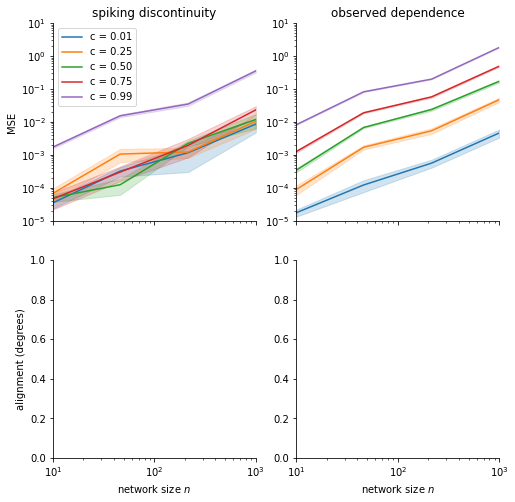

In [76]:
fig,axes = plt.subplots(2,2,figsize=(8,8), sharex = True)
pal = sns.color_palette()
for i in range(len(cvals)):
    #tsplot(data = mean_beta_aln_c[i,:,:].T, ax = axes[1,0], color = pal[i], xvals = Nvals)
    #tsplot(data = mean_beta_aln_fd_c[i,:,:].T, ax = axes[1,1], color = pal[i], xvals = Nvals)
    tsplot(data = mean_beta_c[i,:,:].T, ax = axes[0,0], color = pal[i], xvals = Nvals)
    tsplot(data = mean_beta_fd_c[i,:,:].T, ax = axes[0,1], color = pal[i], xvals = Nvals)

axes[1,0].set_xlabel('network size $n$');
axes[1,1].set_xlabel('network size $n$');
axes[0,0].set_ylabel('MSE');
axes[1,0].set_ylabel('alignment (degrees)');
axes[0,0].set_title('spiking discontinuity');
axes[0,1].set_title('observed dependence');
axes[0,0].set_xscale('log')
axes[0,1].set_xscale('log')
axes[0,0].set_ylim([1e-5, 1e1])
axes[0,1].set_ylim([1e-5, 1e1])
axes[1,0].set_xscale('log')
axes[1,1].set_xscale('log')
axes[0,0].set_yscale('log')
axes[0,1].set_yscale('log')
sns.despine(trim=True)
axes[0,0].legend(["c = %.2f"%i for i in cvals], loc= 'upper left');
plt.savefig('./fig_7_networksize_mse.pdf')

In [57]:
mean_beta_fd_c

array([[[1.26929950e-09, 2.47463026e-09, 1.60674011e-09, 1.41279400e-08,
         1.73644414e-10, 1.15652136e-09, 3.08605873e-12, 5.49017017e-10,
         3.19841720e-10, 5.40496514e-08],
        [6.38014277e-09, 2.72532762e-09, 1.81034984e-09, 1.33044296e-10,
         1.40113592e-12, 7.89762492e-11, 2.45264203e-09, 1.33541181e-10,
         1.17949732e-08, 1.59700773e-08],
        [6.41644440e-10, 7.56992181e-11, 6.99269550e-09, 2.11515103e-09,
         3.30610576e-09, 3.26558019e-12, 9.61852458e-10, 1.58272429e-10,
         2.54462847e-09, 2.33497357e-10],
        [1.02894644e-10, 3.32333741e-11, 1.12065123e-10, 6.67929402e-10,
         4.11655964e-10, 7.09121201e-10, 7.29105174e-12, 7.06405593e-11,
         2.70407294e-11, 2.92392493e-10]]])